In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/language-translatorgerman-to-english/deu.txt


In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import pickle
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
        
    # read all text
    text = file.read()
    file.close()
    return text

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("../input/language-translatorgerman-to-english/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [6]:
deu_eng = deu_eng[:30000,:]


In [7]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [8]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

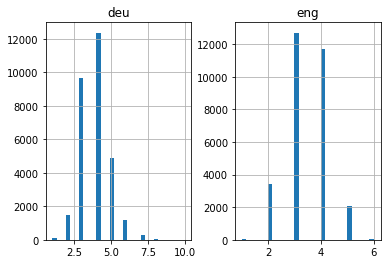

In [9]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [10]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [11]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4726


In [12]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 11
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 7557


In [13]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [15]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
trainY.shape

(24000, 8)

In [17]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [18]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 11, 512)           3869184   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 8, 4726)           2424438   
Total params: 10,492,022
Trainable params: 10,492,022
Non-trainable params: 0
_________________________________________________________________


In [20]:
print("English volcaulary size",eng_vocab_size)
print("German volcaulary size",deu_vocab_size)

English volcaulary size 4726
German volcaulary size 7557


In [21]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [22]:
filename = 'model.h1.G2E'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 19200 samples, validate on 4800 samples
Epoch 1/10
19200/19200 [==============================] - 6s 291us/step - loss: 3.4687 - val_loss: 2.7106

Epoch 00001: val_loss improved from inf to 2.71064, saving model to model.h1.G2E
Epoch 2/10
19200/19200 [==============================] - 3s 165us/step - loss: 2.6015 - val_loss: 2.5648

Epoch 00002: val_loss improved from 2.71064 to 2.56483, saving model to model.h1.G2E
Epoch 3/10
19200/19200 [==============================] - 3s 168us/step - loss: 2.4978 - val_loss: 2.5036

Epoch 00003: val_loss improved from 2.56483 to 2.50356, saving model to model.h1.G2E
Epoch 4/10
19200/19200 [==============================] - 3s 167us/step - loss: 2.3906 - val_loss: 2.3950

Epoch 00004: val_loss improved from 2.50356 to 2.39497, saving model to model.h1.G2E
Epoch 5/10
19200/19200 [==============================] - 3s 171us/step - loss: 2.2677 - val_loss: 2.2910

Epoch 00005: val_loss improved from 2.39497 to 2.29101, saving model to model.h1

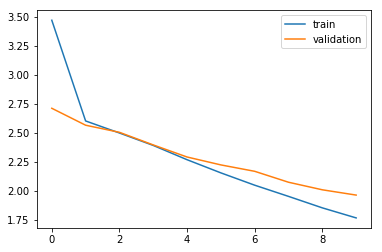

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [24]:
model = load_model('model.h1.G2E')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [25]:
# Saving the Tokenizer model in Pickle files
gmfile = open('German', 'ab')
engfile= open("English",'ab')
# source, destination 
pickle.dump(deu_tokenizer, gmfile)                      
gmfile.close()
eng_tokenizer
pickle.dump(eng_tokenizer, engfile)                      
engfile.close()

In [26]:
"""def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None"""

'def get_word(n, tokenizer):\n    for word, index in tokenizer.word_index.items():\n        if index == n:\n            return word\n    return None'

In [27]:
preds.shape

(6000, 8)

In [28]:
# Function to get word for the model's output numbers
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# Loop for the final dataset presentation.
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 
    preds_text.append(' '.join(temp))


In [29]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [30]:
pred_df.head(10)

,actual,predicted
0,ich bin zu allem bereit,im not a
1,ich habe einen brief geschrieben,i have a
2,ich bin ingenieur,im not a
3,versuchen sie nicht zu fallen,dont it
4,sie sind piloten,youre not
5,tom rasierte sich,tom felt
6,mein pferd ist weiß,my is
7,tom ist sehr bescheiden,tom is a
8,ich werde dir nicht helfen,i cant tom
9,das tut es,it


* English to German Conversion

In [31]:
# prepare english tokenizer
eng1_tokenizer1 = tokenization(deu_eng[:, 0])
eng1_vocab_size1 = len(eng1_tokenizer1.word_index) + 1

eng1_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare Deutch tokenizer
deu1_tokenizer1 = tokenization(deu_eng[:, 1])
deu_vocab_size1 = len(deu1_tokenizer1.word_index) + 1

deu_length = 11
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# prepare training data
trainX1 = encode_sequences(eng1_tokenizer1, eng_length, train[:, 0])
trainY1 = encode_sequences(deu1_tokenizer1, deu_length, train[:, 1])

# prepare validation data
testX1 = encode_sequences(eng1_tokenizer1, eng_length, test[:, 0])
testY1 = encode_sequences(deu1_tokenizer1, deu_length, test[:, 1])



English Vocabulary Size: 4726
Deutch Vocabulary Size: 7557


In [32]:
trainX1.shape

(24000, 8)

In [33]:
trainY1.shape

(24000, 11)

In [34]:
# build NMT model
def define_model1(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

# model compilation
model_2 = define_model1(eng_vocab_size, deu_vocab_size, eng_length, deu_length, 512)

rms = optimizers.RMSprop(lr=0.001)
model_2.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

filename = 'model.h1.E2G'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history1 = model_2.fit(trainX1, trainY1.reshape(trainY1.shape[0], trainY1.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 19200 samples, validate on 4800 samples
Epoch 1/10
19200/19200 [==============================] - 5s 278us/step - loss: 3.1229 - val_loss: 2.2645

Epoch 00001: val_loss improved from inf to 2.26452, saving model to model.h1.E2G
Epoch 2/10
19200/19200 [==============================] - 4s 209us/step - loss: 2.2009 - val_loss: 2.2575

Epoch 00002: val_loss improved from 2.26452 to 2.25747, saving model to model.h1.E2G
Epoch 3/10
19200/19200 [==============================] - 4s 215us/step - loss: 2.1020 - val_loss: 2.1234

Epoch 00003: val_loss improved from 2.25747 to 2.12344, saving model to model.h1.E2G
Epoch 4/10
19200/19200 [==============================] - 4s 215us/step - loss: 1.9926 - val_loss: 2.0698

Epoch 00004: val_loss improved from 2.12344 to 2.06983, saving model to model.h1.E2G
Epoch 5/10
19200/19200 [==============================] - 4s 215us/step - loss: 1.8972 - val_loss: 2.0188

Epoch 00005: val_loss improved from 2.06983 to 2.01884, saving model to model.h1

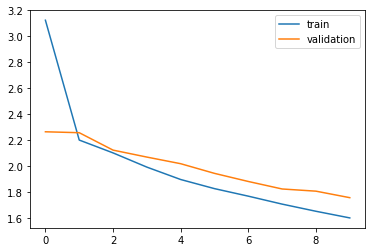

In [35]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [36]:
testX1.shape

(6000, 8)

In [37]:
model1 = load_model('model.h1.E2G')
preds1 = model1.predict_classes(testX1.reshape((testX1.shape[0],testX1.shape[1])))

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [38]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None


preds_text1 = []
for i in preds1:
    temp1 = []
    for j in range(len(i)):
        t = get_word(i[j], eng1_tokenizer1)
        if j > 0:
            if (t == get_word(i[j-1], eng1_tokenizer1)) or (t == None):
                temp1.append('')
            else:
                temp1.append(t)
        else:
            if(t == None):
                temp1.append('')
            else:
                temp1.append(t) 
    preds_text1.append(' '.join(temp1))

In [39]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [40]:
pred_df.head()

,actual,predicted
0,ich bin zu allem bereit,im not a
1,ich habe einen brief geschrieben,i have a
2,ich bin ingenieur,im not a
3,versuchen sie nicht zu fallen,dont it
4,sie sind piloten,youre not
